# Download requirements

In [ ]:
install.packages('fpp2')

In [1]:
library(fpp2)

Warning message:
"package 'fpp2' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
-- Attaching packages ---------------------------------------------- fpp2 2.4 --
v ggplot2   3.1.1     v fma       2.4  
v forecast  8.14      v expsmooth 2.3  
Warning message:
"package 'forecast' was built under R version 3.6.3"Warning message:
"package 'fma' was built under R version 3.6.3"Warning message:
"package 'expsmooth' was built under R version 3.6.3"


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Predict cho Shops portfolio

#### Lấy dữ liệu của Shops porfolio

In [4]:
series <- ts(data = data$Shops, start = c(1963,7), end = c(2022,4), frequency = 12)

In [5]:
series %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-28.060  -1.950   1.035   1.055   4.192  25.980 

#### Khảo sát tập train từ 7/1963 - 12/1989

In [6]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [7]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale

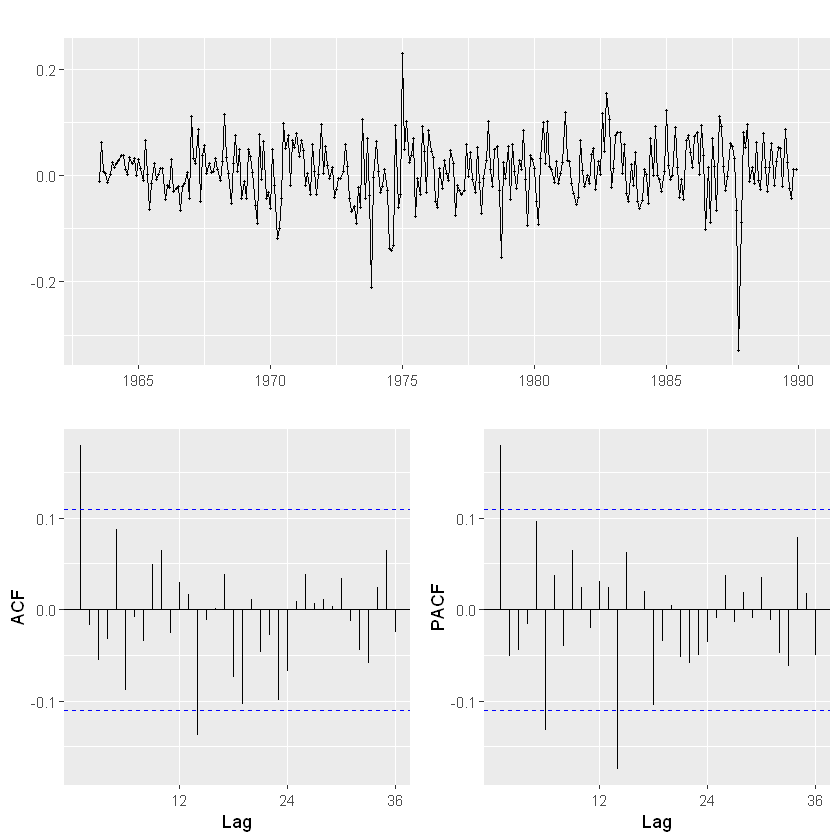

In [8]:
series_train %>% ggtsdisplay()

Biểu đồ dao động không có trend và seasonality quan sát được, nên không cần lấy difference và seasonal difference. <br>
Thử lại với hàm dò tìm bậc d: ndiffs cho order và nsdiffs cho seasonal.

In [9]:
series_train %>% ndiffs()

[1] 0

In [10]:
series_train %>% nsdiffs()

[1] 0

Kết quả d = 0 cho cả order và seasonal.

#### Phân tích p và q cho mô hình ARIMA

Thử dò tìm (p,d,q) với chế độ auto theo thuật toán Hyndman-Khandakar.

In [11]:
fit <- auto.arima(series_train, stepwise = FALSE, approximation = FALSE)
fit

Series: series_train 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
         ma1    mean
      0.1878  0.0093
s.e.  0.0551  0.0037

sigma^2 estimated as 0.003169:  log likelihood=464.69
AIC=-923.38   AICc=-923.31   BIC=-912.1


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with non-zero mean
Q* = 32.549, df = 22, p-value = 0.0685

Model df: 2.   Total lags used: 24



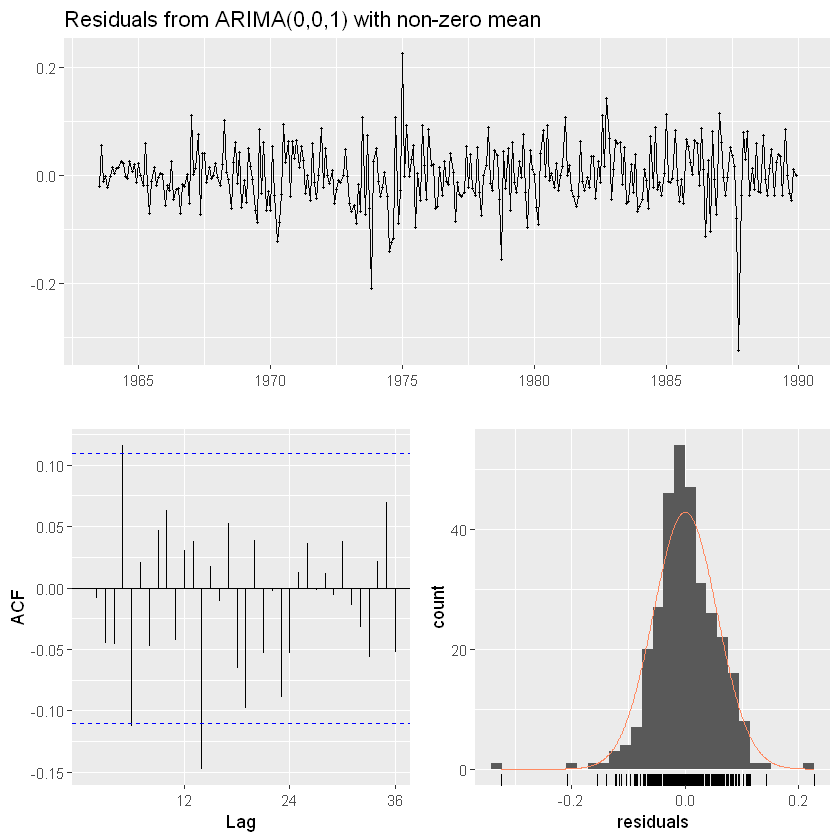

In [12]:
fit %>% checkresiduals()

Auto đề xuất ARIMA(0,0,1), Ljung-Box test cho p-value > 0.05 nên mô hình phù hợp.

Thử tất cả các mô hình đề xuất và so sánh theo tiêu chuẩn thông tin AIC, AICc, BIC, RMSE.

In [13]:
model <- list(ARIMA000 = c(0,0,0), ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA100 = c(1,0,0), ARIMA101 = c(1,0,1), 
              ARIMA102 = c(1,0,2), ARIMA200 = c(2,0,0), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2))

In [14]:
result <- NULL
for (m in model)
{
    fit <- Arima(series_train, order = m)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(model)
result

,AIC,AICc,BIC,RMSE
ARIMA000,-914.4006,-914.3625,-906.8765,5.683775
ARIMA001,-923.3817,-923.3053,-912.0955,5.598247
ARIMA002,-921.3850,-921.2572,-906.3368,5.598172
ARIMA100,-922.8112,-922.7348,-911.5250,5.602511
ARIMA101,-921.3840,-921.2562,-906.3357,5.598193
ARIMA102,-928.6340,-928.4417,-909.8238,5.499329
ARIMA200,-921.6388,-921.5110,-906.5906,5.596087
ARIMA201,-920.0493,-919.8570,-901.2390,5.592233
ARIMA202,-925.7754,-925.5053,-903.2031,5.468253


Mô hình ARIMA(2,0,2) cho kết quả RMSE thấp nhất trên tập train.

#### Đánh giá mô hình ARIMA(2,0,2) trên tập test

In [7]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end = length(series)-388+i) %>% log_scale
    fit <- Arima(train, order = c(2,0,2))
    pred <- c(pred, forecast(fit, h = 1)$mean %>% log_inv) 
}
pred <- ts(data = pred, start = c(1990,1), frequency = 12)
true <- series %>% window(start = c(1990,1))
rmse <- sqrt(mean((true-pred)^2))
rmse

[1] 4.719687

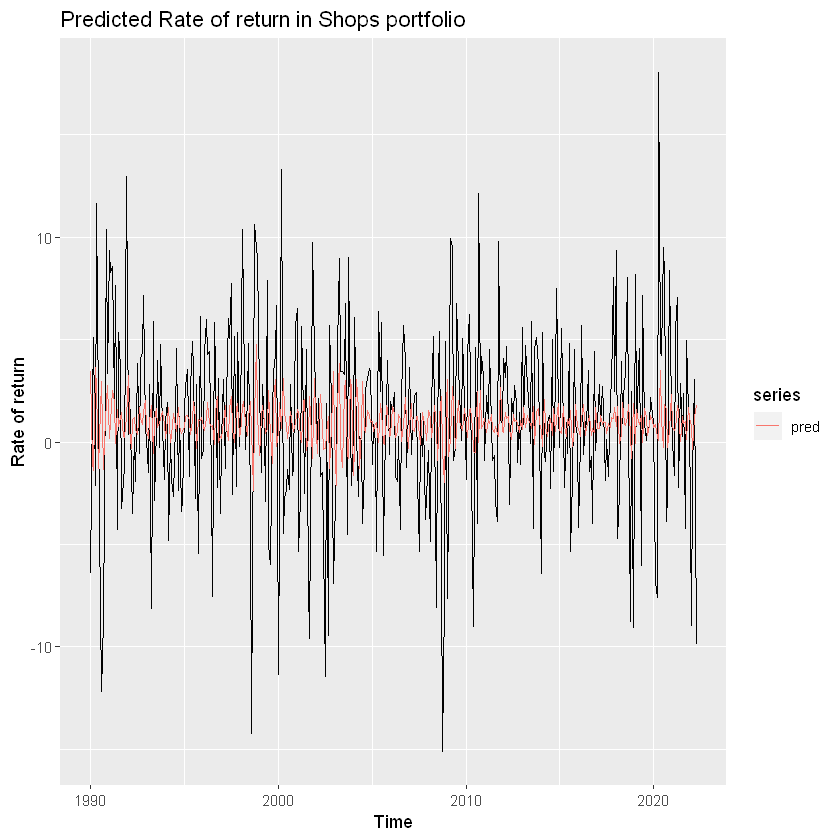

In [8]:
autoplot(true) + autolayer(pred) + labs(y = "Rate of return", title = "Predicted Rate of return in Shops portfolio")

In [9]:
as.numeric(pred)

[1]  3.4234401326 -0.9800057533 -1.3712443256  3.6292726944  2.6348047780
  [6] -1.2717664732  0.1803663631  2.9635401066 -1.3350683616  0.0579161071
 [11]  1.9974465584  2.7541964301  0.1541640738  0.9722590726  2.5066619843
 [16]  1.9662804678 -0.0524144090  1.5858152008  0.7394802893  1.1472117878
 [21]  1.4574771941  0.2806600721  0.2376705786  1.2173362415  3.2382533518
 [26]  0.6378178401 -0.3306048699  1.1023281456  1.2121594250  0.6161549197
 [31]  0.3795511921  1.6613027257  1.1415312054  0.8604326372  1.4507182774
 [36]  2.0111014357  0.5983939614  0.1859375050  0.9839436175  1.8041556550
 [41] -0.5620093086  1.0953098413  1.6269579610  0.7032819629  0.9080547946
 [46]  1.0863861829  1.5078963913  0.8907753899  0.1821875412  1.0813405068
 [51]  1.7012431276 -0.0322730947  0.3028026456  1.3863454790  0.7549259648
 [56]  0.5320389255  1.6778362213  0.7640906067  0.3935182829  0.5140189100
 [61]  0.7153487340  1.2255205305  1.3036182568  1.0701242059  0.3428489128
 [66]  1.0707980874  1.9606413308  1.1719830867 -0.2928014572  1.0995292507
 [71]  1.0295941838  1.2207089484  0.7618934127  0.5518430305  1.1258541709
 [76]  1.9300662560  0.9311877603  0.7365956054  0.8189811691 -0.1409355807
 [81]  1.4688017042  2.2264758946 -0.0107710744  0.2487120414  0.1618361177
 [86]  0.9769563058  1.8025271105  0.7277729598  0.0878997351  1.7082838970
 [91]  2.2059490200  0.6010682700 -0.0003390448  1.5931303070  1.8865092143
 [96]  0.2706362950  0.4119717761  1.7403396152  1.9559720833  0.9328085111
[101]  0.3303690346  1.2231922398  1.9643057301  0.6013426720 -2.3497934061
[106]  1.2643034591  4.7487517858  1.3221450890 -0.6530942070  1.2540267980
[111]  1.7957103636  0.9761814418  0.4045193146  0.6553787603  2.5066948807
[116]  0.3676876109 -1.0551949033  1.8814483501  3.0328761700 -0.1963620307
[121]  0.4873794934  1.9119104847  0.6511612479  3.1108827171  1.4517197952
[126]  0.8075718548  0.1513192027  1.0006457921  1.4710367582  0.7759943303
[131]  0.4954744551  0.9733030989  1.6012060393  1.5016095513  0.2118856718
[136] -0.0199546655  2.0100496001  2.0849673709 -0.4311637946  0.1889958482
[141]  2.2445726158  0.3637286101 -0.8153992842  3.0790021236  1.3579823030
[146] -0.5680541148  0.6928008405  2.3380047229  0.7197780666 -0.3890311439
[151] -0.3127589070  0.4101056448  1.2484660303 -1.2869778919  0.7642708816
[156]  3.4529707019  0.1521414869 -2.1028596976  1.8617888352  3.8142500070
[161] -0.0604768666 -1.2407649339  2.5726992564  2.9947446735 -0.6784286403
[166] -0.8184323794  3.0639167115  2.5949419602 -1.6266034606 -0.3164537635
[171]  3.0533452424  1.6018002608 -1.2830245088  0.5905900290  2.9670727431
[176]  0.5993223808  0.4855968667  1.5430062152  1.3565753284  0.9769565957
[181]  1.0252257389  0.4957389115  0.9203799805  0.9686251106 -0.0383893238
[186]  1.8686321006  1.4293767293 -0.0836369938 -0.1347885253  1.7842015609
[191]  1.6921457509  0.2469078418  0.3253318998  1.7492834052  1.3851371588
[196]  0.2359365166  0.4905509110  1.3406182819  1.1121050096  0.0069498970
[201]  0.8553735760  2.1719686171  0.9387504001 -0.3263265329  0.8008616539
[206]  1.8885089042  0.6283496886  0.5279057589  1.2482982334  1.2583280547
[211]  0.3098906287 -0.1385862285  1.4386947082  1.0886622074  0.7761629761
[216]  0.0673084728  1.5535546877  1.1871821695  0.1974837637  1.0759292468
[221]  1.7761761472  0.6909339283 -0.9187595227  1.2974473303  2.2216096561
[226] -0.4434645274 -1.9901020737  0.6289797508  3.0422110310 -0.7295101609
[231]  0.1344302889  2.7042661036  1.8193358621 -0.3166235955  0.5497562651
[236]  2.0485390000  0.9861553392  0.7286089445  0.5829706293  1.6120101359
[241]  0.8166101227  0.1966475825  1.6026697995  1.6235350862  0.6991303931
[246] -0.4533220062 -0.4920489239  2.4473761939 -0.0160299729  2.5078656422
[251]  0.6829513631  0.8788824029  1.1495842738  0.4489672517  1.1171202663
[256]  0.9212019743  1.3606907676  0.6653531842  0.4592438547  0.7696998774
[261]  0.4203484033  0.2764136881  2.6410951114  0